# ![TensorFlow](https://img.shields.io/badge/TensorFlow-%23FF6F00.svg?style=for-the-badge&logo=TensorFlow&logoColor=white) **LOADING AND PREPROCESSING DATA WITH TENSORFLOW - EXERCISES**

---

## **SETUP:**

In [2]:
# %load ../initial_settings.py
"""
Initial settings for data analysis and machine learning.
Use this with: %load ../initial_settings.py
"""

import os
import sys
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import keras_tuner as kt
from packaging import version

# This notebook requires Python 3.7 or above and Scikit-Learn 1.0.1 or above.
assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# And TensorFlow 2.8 or above.
assert version.parse(tf.__version__) >= version.parse("2.8.0")

# Graphviz source.
os.environ["PATH"] += os.pathsep + "C:/Programy/Graphviz/bin/"

# Default settings for matplotlib.
DARK_BLUE = "#03002e"
LIGHT_GRAY = "#8f8f99"

plt.rc("font", size=14)
plt.rc("legend", fontsize=14)
plt.rc("text", color=DARK_BLUE)

plt.rc("axes", labelsize=14)
plt.rc("axes", titlesize=14)
plt.rc("axes", labelpad=10)
plt.rc("axes", labelcolor=DARK_BLUE)
plt.rc("axes", grid=True)

plt.rc("xtick", labelsize=12, color=DARK_BLUE)
plt.rc("ytick", labelsize=12, color=DARK_BLUE)
plt.rc("xtick.major", pad=10)
plt.rc("ytick.major", pad=10)

plt.rc("grid", color=LIGHT_GRAY)
plt.rc("grid", linestyle="dashed")
plt.rc("grid", linewidth=0.5)
plt.rc("grid", alpha=0.5)

# Create a directory for matplotlib images.
IMAGES_PATH = Path("images")
IMAGES_PATH.mkdir(parents=True, exist_ok=True)


def save_fig(
    fig_id, tight_layout=True, fig_extension="png", resolution=300, facecolor="w"
):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, facecolor=facecolor)


---

## **EXERCISE 01:**

### a.
_Exercise: Load the Fashion MNIST dataset (introduced in Chapter 10); split it into a training set, a validation set, and a test set; shuffle the training set; and save each dataset to multiple TFRecord files. Each record should be a serialized `Example` protobuf with two features: the serialized image (use `tf.io.serialize_tensor()` to serialize each image), and the label. Note: for large images, you could use `tf.io.encode_jpeg()` instead. This would save a lot of space, but it would lose a bit of image quality._

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]


In [6]:
tf.random.set_seed(42)

train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_set = train_set.shuffle(len(X_train), seed=42)

valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))


In [7]:
from tensorflow.train import Example, Features, Feature, BytesList, Int64List


def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    # image_data = tf.io.encode_jpeg(image[..., np.newaxis])
    return Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label])),
            }
        )
    )


In [8]:
for image, label in valid_set.take(1):
    print(create_example(image, label))


features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\001\000\000\rI\000\000\001\004\000\000\000\000\001\001\000\000\000\000\000\000\000\000\000\000\000\000\000\003\000$\210\177>6\000\000\000\001\003\004\000\000\003\000\000\000\000\000\000\000\000\000\000\000\000\006\000f\314\260\206\220{\027\000\000\000\000\014\n\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\233\354\317\262k\234\241m@\027M\202H\017\000\000\000\000\000\000\000\000\000\000\000\001\000E\317\337\332\330\330\243\177yz\222\215X\254B\000\000\00

The following function saves a given dataset to a set of TFRecord files. The examples are written to the files in a round-robin fashion. To do this, we enumerate all the examples using the `dataset.enumerate()` method, and we compute `index % n_shards` to decide which file to write to. We use the standard `contextlib.ExitStack` class to make sure that all writers are properly closed whether or not an I/O error occurs while writing.

In [9]:
from contextlib import ExitStack


def write_tfrecords(name, dataset, n_shards=10):
    path_pattern = "{}.tfrecord-{:05d}-of-{:05d}"
    paths = [path_pattern.format(name, index, n_shards) for index in range(n_shards)]

    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path)) for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())

    return paths


In [12]:
train_filepaths = write_tfrecords("data/mnist/my_fashion_mnist.train", train_set)
valid_filepaths = write_tfrecords("data/mnist/my_fashion_mnist.valid", valid_set)
test_filepaths = write_tfrecords("data/mnist/my_fashion_mnist.test", test_set)


### b.
_Exercise: Then use tf.data to create an efficient dataset for each set. Finally, use a Keras model to train these datasets, including a preprocessing layer to standardize each input feature. Try to make the input pipeline as efficient as possible, using TensorBoard to visualize profiling data._

In [13]:
def preprocess(tfrecord):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1),
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    # image = tf.io.decode_jpeg(example["image"])
    image = tf.reshape(image, shape=[28, 28])
    return image, example["label"]


def mnist_dataset(
    filepaths,
    n_read_threads=5,
    shuffle_buffer_size=None,
    n_parse_threads=5,
    batch_size=32,
    cache=True,
):
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)


In [15]:
train_set = mnist_dataset(train_filepaths, shuffle_buffer_size=60000)
valid_set = mnist_dataset(valid_filepaths)
test_set = mnist_dataset(test_filepaths)


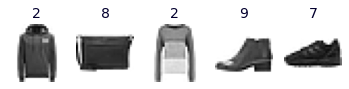

In [18]:
for X, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))

In [29]:
tf.random.set_seed(42)

sample_image_batches = train_set.take(100).map(lambda image, label: image)
sample_images = np.concatenate(
    list(sample_image_batches.as_numpy_iterator()), axis=0
).astype(np.float32)

standarization = tf.keras.layers.Normalization(input_shape=[28, 28])
standarization.adapt(sample_images)

model = tf.keras.Sequential(
    [
        standarization,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

model.compile(
    loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"]
)


In [30]:
from time import strftime

logs = Path() / "logs" / strftime("run_%Y-%m-%d_%H-%M-%S")

tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=logs, histogram_freq=1, profile_batch=10
)

model.fit(train_set, epochs=5, validation_data=valid_set, callbacks=[tensorboard_cb])


Epoch 1/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4442 - accuracy: 0.8405 - val_loss: 0.3686 - val_accuracy: 0.8636
Epoch 2/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3364 - accuracy: 0.8769 - val_loss: 0.3499 - val_accuracy: 0.8714
Epoch 3/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2977 - accuracy: 0.8900 - val_loss: 0.3287 - val_accuracy: 0.8850
Epoch 4/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2721 - accuracy: 0.8981 - val_loss: 0.3392 - val_accuracy: 0.8826
Epoch 5/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2537 - accuracy: 0.9074 - val_loss: 0.3345 - val_accuracy: 0.8860


---

## **EXERCISE 02:**

_Exercise: In this exercise you will download a dataset, split it, create a `tf.data.Dataset` to load it and preprocess it efficiently, then build and train a binary classification model containing an `Embedding` layer._

### a.
_Exercise: Download the [Large Movie Review Dataset](https://homl.info/imdb), which contains 50,000 movies reviews from the [Internet Movie Database](https://imdb.com/). The data is organized in two directories, `train` and `test`, each containing a `pos` subdirectory with 12,500 positive reviews and a `neg` subdirectory with 12,500 negative reviews. Each review is stored in a separate text file. There are other files and folders (including preprocessed bag-of-words), but we will ignore them in this exercise._

In [37]:
root = "https://ai.stanford.edu/~amaas/data/sentiment/"
filename = "aclImdb_v1.tar.gz"
filepath = tf.keras.utils.get_file(
    filename, root + filename, extract=True, cache_dir="."
)
path = Path(filepath).with_name("aclImdb")
path


WindowsPath('datasets/aclImdb')

Let's define a `tree()` function to view the structure of the `aclImdb` directory:

In [106]:
def tree(path, level=0, indent=4, max_files=3):
    if level == 0:
        print(f"{path}/".replace("\\", "/"))
        level += 1

    sub_paths = sorted(path.iterdir())
    sub_dirs = [sub_path for sub_path in sub_paths if sub_path.is_dir()]
    filepaths = [sub_path for sub_path in sub_paths if not sub_path in sub_dirs]

    indent_str = " " * indent * level

    for sub_dir in sub_dirs:
        print(f"{indent_str}{sub_dir.name}/")
        tree(sub_dir, level + 1, indent)

    for filepath in filepaths[:max_files]:
        print(f"{indent_str}{filepath.name}")

    if len(filepaths) > max_files:
        print(f"{indent_str}...")


In [107]:
tree(path)

datasets/aclImdb/
    test/
        neg/
            0_2.txt
            10000_4.txt
            10001_1.txt
            ...
        pos/
            0_10.txt
            10000_7.txt
            10001_9.txt
            ...
        labeledBow.feat
        urls_neg.txt
        urls_pos.txt
    train/
        neg/
            0_3.txt
            10000_4.txt
            10001_4.txt
            ...
        pos/
            0_9.txt
            10000_8.txt
            10001_10.txt
            ...
        unsup/
            0_0.txt
            10000_0.txt
            10001_0.txt
            ...
        labeledBow.feat
        unsupBow.feat
        urls_neg.txt
        ...
    imdb.vocab
    imdbEr.txt
    README


In [68]:
def review_paths(dirpath):
    return [str(path) for path in dirpath.glob("*.txt")]


train_pos = review_paths(path / "train" / "pos")
train_neg = review_paths(path / "train" / "neg")
test_valid_pos = review_paths(path / "test" / "pos")
test_valid_neg = review_paths(path / "test" / "neg")

len(train_pos), len(train_neg), len(test_valid_pos), len(test_valid_neg)


(12500, 12500, 12500, 12500)

### b.
_Exercise: Split the test set into a validation set (15,000) and a test set (10,000)._

In [79]:
np.random.shuffle(test_valid_pos)
np.random.shuffle(test_valid_neg)

test_pos = test_valid_pos[:5000]
test_neg = test_valid_neg[:5000]

valid_pos = test_valid_pos[5000:]
valid_neg = test_valid_neg[5000:]


### c.
_Exercise: Use tf.data to create an efficient dataset for each set._

Since the dataset fits in memory, we can just load all the data using pure Python code and use `tf.data.Dataset.from_tensor_slices()`:

In [80]:
def imdb_dataset(filepaths_positive, filepaths_negative):
    reviews, labels = [], []

    for filepaths, label in ((filepaths_negative, 0), (filepaths_positive, 1)):
        for filepath in filepaths:
            with open(filepath, "r", encoding="utf-8") as review_file:
                reviews.append(review_file.read())
            labels.append(label)

    return tf.data.Dataset.from_tensor_slices(
        (tf.constant(reviews), tf.constant(labels))
    )


In [81]:
for X, y in imdb_dataset(train_pos, train_neg).take(3):
    print(X)
    print(y)
    print()


tf.Tensor(b"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)

tf.Tensor(b"Airport '77 starts as a brand new luxury 747 plane is loaded up with valuable paintings & such belonging to rich businessman Philip Stevens (James Stewart) who is flying them & a bunch of VIP's to his estate in preparation of it being opened to the public a

In [82]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).repeat(10): pass

30.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


But let's pretend the dataset does not fit in memory, just to make things more interesting. Luckily, each review fits on just one line (they use `<br />` to indicate line breaks), so we can read the reviews using a `TextLineDataset`. If they didn't we would have to preprocess the input files (e.g., converting them to TFRecords). For very large datasets, it would make sense to use a tool like Apache Beam for that.

In [85]:
def imdb_dataset(filepaths_positive, filepaths_negative, n_read_threads=5):
    dataset_neg = tf.data.TextLineDataset(
        filepaths_negative, num_parallel_reads=n_read_threads
    )
    dataset_neg = dataset_neg.map(lambda review: (review, 0))

    dataset_pos = tf.data.TextLineDataset(
        filepaths_positive, num_parallel_reads=n_read_threads
    )
    dataset_pos = dataset_pos.map(lambda review: (review, 1))

    return tf.data.Dataset.concatenate(dataset_pos, dataset_neg)


In [86]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).repeat(10): pass

38 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Now it takes about 33 seconds to go through the dataset 10 times. That's much slower, essentially because the dataset is not cached in RAM, so it must be reloaded at each epoch. If you add `.cache()` just before `.repeat(10)`, you will see that this implementation will be about as fast as the previous one.

In [87]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).cache().repeat(10): pass

29.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [108]:
batch_size = 32

train_set = (
    imdb_dataset(train_pos, train_neg)
    .shuffle(25_000, seed=42)
    .batch(batch_size)
    .prefetch(1)
)
valid_set = imdb_dataset(valid_pos, valid_neg).batch(batch_size).prefetch(1)
test_set = imdb_dataset(test_pos, test_neg).batch(batch_size).prefetch(1)


### d.
_Exercise: Create a binary classification model, using a `TextVectorization` layer to preprocess each review._

Let's create a `TextVectorization` layer and adapt it to the full IMDB training set (if the training set did not fit in RAM, we could just use a smaller sample of the training set by calling `train_set.take(500)`). Let's use TF-IDF for now.

In [110]:
max_tokens = 1000
sample_reviews = train_set.map(lambda review, label: review)
text_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens, output_mode="tf_idf"
)
text_vectorization.adapt(sample_reviews)


Good! Now let's take a look at the first 10 words in the vocabulary:

In [112]:
text_vectorization.get_vocabulary()[:10]

['[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i']

These are the most common words in the reviews.

We're ready to train the model!

In [114]:
tf.random.set_seed(42)

model = tf.keras.Sequential(
    [
        text_vectorization,
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set)


Epoch 1/5
782/782 [==============================] - 8s 8ms/step - loss: 0.4523 - accuracy: 0.8161 - val_loss: 0.3974 - val_accuracy: 0.8373
Epoch 2/5
782/782 [==============================] - 7s 7ms/step - loss: 0.3532 - accuracy: 0.8574 - val_loss: 0.3757 - val_accuracy: 0.8471
Epoch 3/5
782/782 [==============================] - 7s 8ms/step - loss: 0.3100 - accuracy: 0.8729 - val_loss: 0.3696 - val_accuracy: 0.8459
Epoch 4/5
782/782 [==============================] - 7s 7ms/step - loss: 0.2539 - accuracy: 0.8960 - val_loss: 0.3641 - val_accuracy: 0.8535
Epoch 5/5
782/782 [==============================] - 7s 8ms/step - loss: 0.1981 - accuracy: 0.9215 - val_loss: 0.3968 - val_accuracy: 0.8473


We get about 84.2% accuracy on the validation set after just the first epoch, but after that the model makes no significant progress. We will do better in Chapter 16. For now the point is just to perform efficient preprocessing using `tf.data` and Keras preprocessing layers.

### e.
_Exercise: Add an `Embedding` layer and compute the mean embedding for each review, multiplied by the square root of the number of words (see Chapter 16). This rescaled mean embedding can then be passed to the rest of your model._

To compute the mean embedding for each review, and multiply it by the square root of the number of words in that review, we will need a little function. For each sentence, this function needs to compute $M \times \sqrt N$, where $M$ is the mean of all the word embeddings in the sentence (excluding padding tokens), and $N$ is the number of words in the sentence (also excluding padding tokens). We can rewrite $M$ as $\dfrac{S}{N}$, where $S$ is the sum of all word embeddings (it does not matter whether or not we include the padding tokens in this sum, since their representation is a zero vector). So the function must return $M \times \sqrt N = \dfrac{S}{N} \times \sqrt N = \dfrac{S}{\sqrt N \times \sqrt N} \times \sqrt N= \dfrac{S}{\sqrt N}$.

In [115]:
def compute_mean_embedding(inputs):
    not_pad = tf.math.count_nonzero(inputs, axis=-1)
    n_words = tf.math.count_nonzero(not_pad, axis=-1, keepdims=True)
    sqrt_n_words = tf.math.sqrt(tf.cast(n_words, tf.float32))
    return tf.reduce_sum(inputs, axis=1) / sqrt_n_words


another_example = tf.constant(
    [
        [[1.0, 2.0, 3.0], [4.0, 5.0, 0.0], [0.0, 0.0, 0.0]],
        [[6.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]],
    ]
)
compute_mean_embedding(another_example)


<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[3.535534 , 4.9497476, 2.1213205],
       [6.       , 0.       , 0.       ]], dtype=float32)>

Let's check that this is correct. The first review contains 2 words (the last token is a zero vector, which represents the `<pad>` token). Let's compute the mean embedding for these 2 words, and multiply the result by the square root of 2:

In [117]:
tf.reduce_mean(another_example[0:1, :2], axis=1) * tf.sqrt(2.0)


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[3.535534 , 4.9497476, 2.1213202]], dtype=float32)>

Looks good! Now let's check the second review, which contains just one word (we ignore the two padding tokens):

In [118]:
tf.reduce_mean(another_example[1:2, :1], axis=1) * tf.sqrt(1.0)


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[6., 0., 0.]], dtype=float32)>

Perfect. Now we're ready to train our final model. It's the same as before, except we replaced TF-IDF with ordinal encoding (`output_mode="int"`) followed by an `Embedding` layer, followed by a `Lambda` layer that calls the `compute_mean_embedding` layer:

In [119]:
tf.random.set_seed(42)

embedding_size = 20

text_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens, output_mode="int"
)
text_vectorization.adapt(sample_reviews)

model = tf.keras.Sequential(
    [
        text_vectorization,
        tf.keras.layers.Embedding(
            input_dim=max_tokens,
            output_dim=embedding_size,
            mask_zero=True,  # <pad> tokens => zero vectors
        ),
        tf.keras.layers.Lambda(compute_mean_embedding),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)


### f.
_Exercise: Train the model and see what accuracy you get. Try to optimize your pipelines to make training as fast as possible._

In [120]:
model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set)


Epoch 1/5
782/782 [==============================] - 12s 13ms/step - loss: 0.4696 - accuracy: 0.7775 - val_loss: 0.3410 - val_accuracy: 0.8568
Epoch 2/5
782/782 [==============================] - 11s 13ms/step - loss: 0.3353 - accuracy: 0.8574 - val_loss: 0.3629 - val_accuracy: 0.8389
Epoch 3/5
782/782 [==============================] - 11s 13ms/step - loss: 0.3179 - accuracy: 0.8631 - val_loss: 0.3146 - val_accuracy: 0.8647
Epoch 4/5
782/782 [==============================] - 10s 12ms/step - loss: 0.3110 - accuracy: 0.8668 - val_loss: 0.3173 - val_accuracy: 0.8621
Epoch 5/5
782/782 [==============================] - 11s 13ms/step - loss: 0.3075 - accuracy: 0.8684 - val_loss: 0.3164 - val_accuracy: 0.8625


The model is just marginally better using embeddings (but we will do better in Chapter 16). The pipeline looks fast enough (we optimized it earlier).

### g.
_Exercise: Use TFDS to load the same dataset more easily: `tfds.load("imdb_reviews")`._

In [121]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="imdb_reviews")
train_set, test_set = datasets["train"], datasets["test"]


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Mateusz\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incompleteRJVTVP\imdb_reviews-tra…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Mateusz\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incompleteRJVTVP\imdb_reviews-tes…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Mateusz\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incompleteRJVTVP\imdb_reviews-uns…

Dataset imdb_reviews downloaded and prepared to C:\Users\Mateusz\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


In [122]:
for example in train_set.take(1):
    print(example["text"])
    print(example["label"])

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
